use pipreqs to freeze only used packages

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# move to root directory of repository
%cd /content/drive/MyDrive/ColabNotebooks/clustered-fl

/content/drive/MyDrive/ColabNotebooks/clustered-fl


In [16]:
!pip install pipreqs


In [27]:
!pipreqs .

In [18]:
%matplotlib inline
from IPython.display import clear_output
import os
from copy import deepcopy

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from models import ConvNet
from helper import ExperimentLogger, display_train_stats
from fl_devices import Server, Client
from data_utils import split_noniid, CustomSubset


torch.manual_seed(42)
np.random.seed(42)

We will run experiments with the EMNIST data set of handwritten characters. We simulate a scenario with 10 clients and distribute the data among the clients in a non-iid way accoding to a dirichlet distribution parametrized with alpha=1.0 . The distribution of data is shown below.

In [19]:
N_CLIENTS = 10
DIRICHLET_ALPHA = 1.0


data = datasets.EMNIST(root=".", split="byclass", download=True)

mapp = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c',
       'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
       'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1')

idcs = np.random.permutation(len(data))
train_idcs, test_idcs = idcs[:10000], idcs[10000:20000]
train_labels = data.train_labels.numpy()

client_idcs = split_noniid(train_idcs, train_labels, alpha=DIRICHLET_ALPHA, n_clients=N_CLIENTS)

client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
test_data = CustomSubset(data, test_idcs, transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [31]:
print(client_idcs[0].shape, client_idcs[1].shape)
print(len(client_idcs))

(1030,) (1334,)
10


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


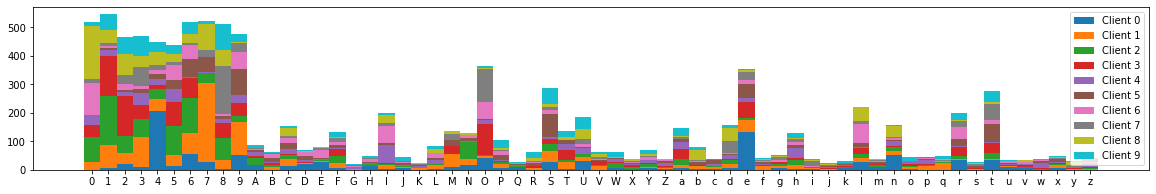

In [20]:
plt.figure(figsize=(20,3))
plt.hist([train_labels[idc]for idc in client_idcs], stacked=True, 
         bins=np.arange(min(train_labels)-0.5, max(train_labels) + 1.5, 1),
        label=["Client {}".format(i) for i in range(N_CLIENTS)])
plt.xticks(np.arange(62), mapp)
plt.legend()
plt.show()

Next, we simulate a clustering structure in the client population, by rotating the data for half of the first 5 clients by 180 degree. We display 10 data samples from the 1st and the 6th client for illustration.

In [21]:
for i, client_datum in enumerate(client_data):
    if i<5:
        client_datum.subset_transform = transforms.Compose([transforms.RandomRotation((180,180)),
                                                      transforms.ToTensor()])
    else:
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

In [22]:
clients = [Client(ConvNet, lambda x : torch.optim.SGD(x, lr=0.1, momentum=0.9), dat, idnum=i) 
           for i, dat in enumerate(client_data)]
server = Server(ConvNet, test_data)

Client 0:


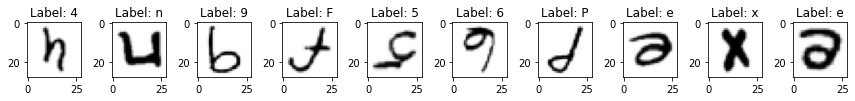

Client 5:


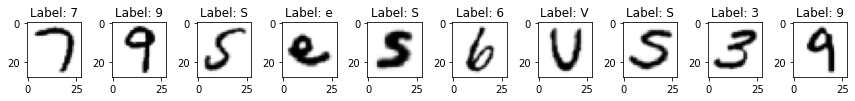

In [23]:
for client in [clients[0], clients[5]]:
    x, y = iter(client.train_loader).next()

    print("Client {}:".format(client.id))
    plt.figure(figsize=(15,1))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(x[i,0].numpy().T, cmap="Greys")
        plt.title("Label: {}".format(mapp[y[i].item()]))
    plt.show()

Now everything is set up to run our Clustered Federated Learning algorithm. During training, we will track the mean and std client accuracies, as well as the average and maximum client update norms.

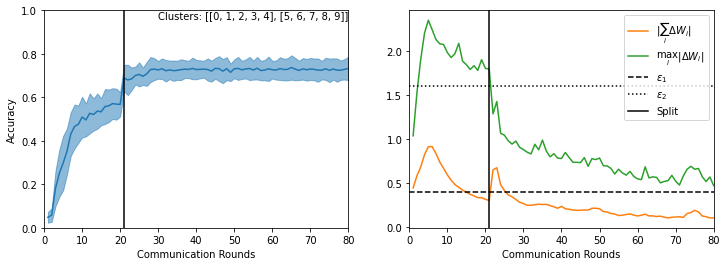

In [33]:
COMMUNICATION_ROUNDS = 80
EPS_1 = 0.4
EPS_2 = 1.6
    
    
cfl_stats = ExperimentLogger()
    
cluster_indices = [np.arange(len(clients)).astype("int")]
# set initial clusters with iid datasets
client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]

print(cluster_indices)
# algorithm can be found at Algorithm 5

for c_round in range(1, COMMUNICATION_ROUNDS+1):

    # initialize
    if c_round == 1:
        for client in clients:
            client.synchronize_with_server(server)

    # client does
    # assume) all clients participate each round (frac = 1.0)
    participating_clients = server.select_clients(clients, frac=1.0)

    for client in participating_clients:
        train_stats = client.compute_weight_update(epochs=1)
        client.reset()

    # line 15
    similarities = server.compute_pairwise_similarities(clients)

    # we start with empty list unlike line 11
    cluster_indices_new = []

    # server does
    for idc in cluster_indices:
        # max norm for line 14
        max_norm = server.compute_max_update_norm([clients[i] for i in idc])
        # line 13
        mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])
        # line 14
        if mean_norm<EPS_1 and max_norm>EPS_2 and len(idc)>2 and c_round>20: # we use cluster since round 20
            
            server.cache_model(idc, clients[idc[0]].W, acc_clients)
            # line 16, use pre-calculated similarites
            c1, c2 = server.cluster_clients(similarities[idc][:,idc]) 
            # line 19, line 18 is not implemented, we cant find gamma implemented
            cluster_indices_new += [c1, c2]
             
            cfl_stats.log({"split" : c_round})

        else:
            cluster_indices_new += [idc]
        
    # line 23
    cluster_indices = cluster_indices_new
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]

    server.aggregate_clusterwise(client_clusters)

    acc_clients = [client.evaluate() for client in clients]
    
    cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : mean_norm, "max_norm" : max_norm,
                  "rounds" : c_round, "clusters" : cluster_indices})
    
    
    display_train_stats(cfl_stats, EPS_1, EPS_2, COMMUNICATION_ROUNDS)

    
for idc in cluster_indices:    
    server.cache_model(idc, clients[idc[0]].W, acc_clients)

The training process resulted in multiple models for every client: A Federated Learning base model as well as more specialized models for the different clusters.  We can now compare their accuracies on the clients' validation sets, and assign each client the model which performed best.

In [25]:
results = np.zeros([10, len(server.model_cache)])
for i, (idcs, W, accs) in enumerate(server.model_cache):
    results[idcs, i] = np.array(accs)

In [26]:
frame = pd.DataFrame(results, columns=["FL Model"]+["Model {}".format(i) 
                                                    for i in range(results.shape[1]-1)],
            index = ["Client {}".format(i) for i in range(results.shape[0])])

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

frame.T.style.apply(highlight_max)

,Client 0,Client 1,Client 2,Client 3,Client 4,Client 5,Client 6,Client 7,Client 8,Client 9
FL Model,0.665049,0.651685,0.625000,0.578059,0.488722,0.617647,0.526012,0.672316,0.575472,0.574468
Model 0,0.757282,0.808989,0.750000,0.784810,0.631579,0.000000,0.000000,0.000000,0.000000,0.000000
Model 1,0.000000,0.000000,0.000000,0.000000,0.000000,0.729412,0.641618,0.762712,0.731132,0.765957


As we can see, clustering improoved the accuracy for all clients by about 10%.